#Regresión logistica

Juan Esteban Acosta López, Carlos Felipe Palacio Lozano

Aprendizaje automático y análisis de datos

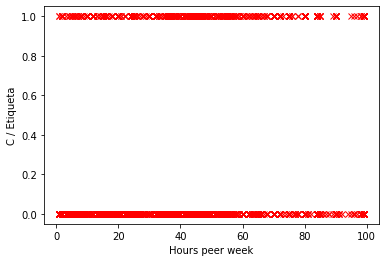

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 
from scipy import optimize
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

url="https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
data = pd.read_csv(url, header=None, na_values=" ?")

#Ponemos nombre a las columnas (Esta información se toma del archivo original adult.names que está en el 
#repositorio junto con el archivo de datos)
data.columns = ['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education-num', 'Marital-status', 'Occupation',
              'Relationship', 'Race', 'Sex', 'Capital-gain', 'Capital-loss', 'Hpw', 'Country', 'C']
data

encoder = LabelEncoder()

data.loc[ :, 'C' ] = encoder.fit_transform( data[ 'C' ] )

# funcion ideal
def flin( x, a, b ):
    return 1 / ( 1 + np.exp( -( a * x + b ) ) )

hwp = data[ 'Hpw' ]
etiqueta = data[ 'C' ]

plt.plot( hwp, etiqueta,'rx' )
plt.xlabel( r'Hours peer week')
plt.ylabel( r'C / Etiqueta')
plt.show()


Vamos a pintar una función logistica sobre estos datos

$$ f_{a,b}\left(\vec{x}^{(i)}\right)=\frac{1}{1+\exp-\left(a\vec{x}+b\right)}$$
Vamos a variar $a,b$ a ver que pasa en los datos


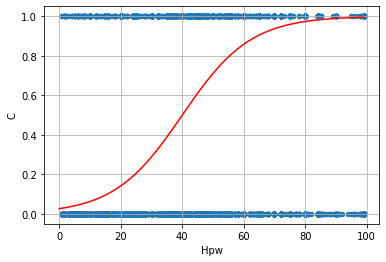

In [ ]:
a = 0.09
b = -3.6

x = np.linspace( 0, data[ 'Hpw' ].max(), 100 )
y = 1 / ( 1 + np.exp( -( a * x + b ) ) )
data.plot.scatter( x = "Hpw", y = "C" )
plt.plot( x, y, '-r')
plt.grid()
plt.show()

Si escogemos esos parametros $a,b$ para el modelo, ¿Qué tan buenos son?

Podemos utilizar la siguiente estrategia:
* calcular el valor de la función logística para cada dato
* calcular la función de pérdida (se denota con L o loss)
* calcular el promedio de la pérdida para obtener el costo (se denota con Jo cost)

Queremos los valores $a,b$ que resulten en un menor costo

Las ecuaciones para las funciones son

$$ L\left(f_{a,b}\left(\vec{x}^{(i)}\right),y^{(i)}\right)=-y^{(i)}\log\left(f_{a,b}\left(\vec{x}^{(i)}\right)\right)-\left(1-y^{(i)}\right)\log\left(1-f_{a,b}\left(\vec{x}^{(i)}\right)\right) $$

$$ J\left(a,b\right)=\frac{1}{m}\sum_{i=1}^{m}\left[L\left(f_{a,b}\left(\vec{x}^{(i)}\right),y^{(i)}\right)\right] $$


In [ ]:
#CALCULO DE LAS PREDICCIONES
data[ 'id' ] = 1 / ( 1 + np.exp( -( data[ 'Hpw' ] * a + b ) ) )

#CALCULO DE LA FUNCION DE ERROR

data[ 'loss_xi' ] = -data[ 'C' ] * np.log( data[ 'id' ] ) - ( 1 - data[ 'C' ] ) * np.log( 1 - data[ 'id' ] )
cost = data[ 'loss_xi' ].mean()
cost

0.7211030339560902

Esto lo hemos hecho con los parametros que hemos obtenido a ojo por ciento. Ahora vamos a ser más refinados y calcularlo para muchos parametros a la vez y luego de ahi mirar el que tenga menor costo.

Para eso hacemos lo siguiente:
* Construimos un dataframe con valores para $a,b$ que varían sobre una cuadricula o grid
* Creamos una función de python que calcule el costo dados parametros $a,b$
* Aplicamos la función sobre el dataframe con los valores $a,b$ en la cuadricula
* Podemos ordenar la tabla resultante para obtener los valores $a,b$ con el menor costo
* Luego hacemos gráficas para verificar el resultado

In [ ]:
# hacemos dataframe para calcular el error en funcion de los parametros a, b

arreglo = np.mgrid[ 0.05:0.15:0.01, -4:-2:0.01 ].reshape( 2,-1 ).T
dataFrame = pd.DataFrame( data = arreglo, 
                  columns = [ 'a','b'] )

# round para solventar problema con muchos decimales
dataFrame[ 'a' ] = np.round( dataFrame['a'], 6 )
dataFrame[ 'b' ] = np.round( dataFrame['b'], 6 )
dataFrame

,a,b
0,0.05,-4.00
1,0.05,-3.99
2,0.05,-3.98
3,0.05,-3.97
4,0.05,-3.96
...,...,...
1995,0.14,-2.05
1996,0.14,-2.04
1997,0.14,-2.03
1998,0.14,-2.02


In [ ]:
def sumaErrorDataFrame( dataFrame ):
  data[ 'id' ] = 1 / ( 1 + np.exp( -( data[ 'Hpw' ] * dataFrame[ 'a' ] + dataFrame[ 'b' ] ) ) )
  data[ 'loss_xi' ] = -data[ 'C' ] * np.log( data[ 'id' ] ) - ( 1 - data[ 'C' ] ) * np.log( 1 - data[ 'id' ] )
  return data[ 'loss_xi' ].mean()

In [ ]:
dataFrame[ 'Error' ] = dataFrame.apply( sumaErrorDataFrame, axis = 1 )

dataFrame.sort_values( by = [ 'Error' ] ).head()

,a,b,Error
75,0.05,-3.25,0.525112
74,0.05,-3.26,0.525114
76,0.05,-3.24,0.525127
73,0.05,-3.27,0.525134
77,0.05,-3.23,0.525159


In [ ]:
dataFrame3d = dataFrame.pivot( index = 'a', columns = 'b', values = 'Error')

dataFrame3d.head()

b,-4.00,-3.99,-3.98,-3.97,-3.96,-3.95,-3.94,-3.93,-3.92,-3.91,...,-2.10,-2.09,-2.08,-2.07,-2.06,-2.05,-2.04,-2.03,-2.02,-2.01
a,,,,,,,,,,,,,,,,,,,,,
0.05,0.567116,0.566071,0.565037,0.564015,0.563004,0.562004,0.561016,0.560039,0.559074,0.558121,...,0.657063,0.659482,0.661925,0.664390,0.666879,0.669391,0.671926,0.674484,0.677066,0.679671
0.06,0.534601,0.534125,0.533664,0.533217,0.532785,0.532367,0.531964,0.531576,0.531203,0.530844,...,0.778568,0.781901,0.785256,0.788633,0.792032,0.795453,0.798897,0.802362,0.805849,0.809358
0.07,0.531837,0.532056,0.532292,0.532545,0.532816,0.533105,0.533410,0.533734,0.534075,0.534434,...,0.936906,0.941064,0.945241,0.949437,0.953654,0.957890,0.962146,0.966421,0.970716,0.975030
0.08,0.563106,0.564116,0.565145,0.566194,0.567262,0.568350,0.569458,0.570585,0.571732,0.572899,...,1.126711,1.131570,1.136445,1.141338,1.146247,1.151173,1.156116,1.161076,1.166052,1.171045
0.09,0.630770,0.632622,0.634496,0.636390,0.638305,0.640240,0.642196,0.644172,0.646170,0.648188,...,1.342044,1.347473,1.352917,1.358374,1.363845,1.369330,1.374829,1.380342,1.385868,1.391408


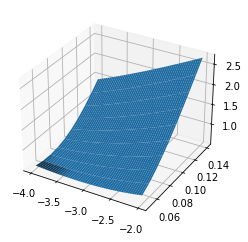

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = dataFrame3d.columns
y = dataFrame3d.index
X, Y = np.meshgrid( x, y )
Z = dataFrame3d

figure = plt.figure()
ax = figure.add_subplot( 111, projection = '3d' )
ax.plot_surface( X, Y, Z )

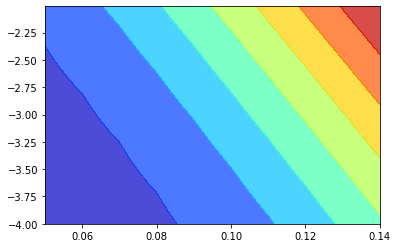

In [ ]:
x = dataFrame3d.columns
y = dataFrame3d.index
X, Y = np.meshgrid( x,y )
Z = dataFrame3d
plt.contourf( Y, X, Z, alpha=0.7, cmap=plt.cm.jet )

Vamos a utilizar el método del gradiente descendente para calcular los valores optimos de $a,b$.

Para esto tenemos que calcular el gradiente para $a,b$ con respecto de la función J (esta es la que hemos gráficado), sus funciones son

$$ \frac{\partial}{\partial a}J\left(a,b\right)=\frac{1}{m}\sum_{i=1}^{m}\left(f_{a,b}\left(\vec{x}^{(i)}\right)-y^{(i)}\right)x^{(i)} $$

$$ \frac{\partial}{\partial b}J\left(a,b\right)=\frac{1}{m}\sum_{i=1}^{m}\left(f_{a,b}\left(\vec{x}^{(i)}\right)-y^{(i)}\right)$$

In [ ]:
#Optimizando los parametros elejidos a ojo
def deltaA( a, b ):
  data[ 'id' ] = 1 / ( 1 + np.exp( -( data[ 'Hpw' ] * a + b ) ) )
  data[ 'loss_xi' ] = ( data[ 'id' ] - data[ 'C' ] ) * data[ 'Hpw' ]
  return data[ 'loss_xi' ].mean()

def deltaB( a, b ):
  data[ 'id' ] = 1 / ( 1 + np.exp( -( data[ 'Hpw' ] * a + b ) ) )
  data[ 'loss_xi' ] = ( data[ 'id' ] - data[ 'C' ] )
  return data[ 'loss_xi' ].mean()

In [ ]:
a0 = 0.09
b0 = -3.6

In [ ]:
#Empezamos a iterar hasta obtener valores que no varíen tanto

for _ in range( 100 ):
  alphaA = 0.001
  alphaB = 0.1

  nuevoA = a0 - alphaA * deltaA( a0, b0 )
  nuevoB = b0 - alphaB * deltaB( a0, b0 )

  a0 = nuevoA
  b0 = nuevoB

print( a0, b0 )

0.05766635386484101 -3.616932503026229
